In [1]:
import os
os.chdir("/Users/users/lourens/RDMP/master_research/code/SGQ_classification/")

# Finding the optimum SDR parameters for the CPz catalog
The code in this notebook demonstrates how I found the optimal parameter sets for the dimensionality reduction (DR) and the local gradient clustering (LGC) components of the sharpened dimensionality reduction (SDR) algorithm for the CPz catalog. For demonstration purposes, I will only show how this was done for the STAR dataset using LMDS as the DR method. However, the code in this notebook can easily be applied to any dataset and DR method by changing a couple of variables.

## Imports

In [2]:
import os
import json
import numpy as np
from astropy.table import Table

import sys
sys.path.insert(1, "/rdmp_data/users/lourens/master_research/code/sdr/python") # add pySDR to system's path
from pySDR.SDR import SDR
from sklearn import preprocessing

from SHARC.optimization_routines import optimize_DR, optimize_LGC
from SHARC.metrics import DR_MetricsV2, LGC_Metrics

import matplotlib.pyplot as plt
from SHARC.plot_funcs import plot_projection, plot_projection_grid, plot_shepard_diagram
from SHARC.utils import writeDataset

# colors used for different classifiers in HDBSCAN paper
colors_STAR = ["Kmag-Y3mag", "Kmag-J3mag", "Kmag-Z3mag", "Kmag-H3mag", "J3mag-K3mag",
               "Y3mag-K3mag", "J3mag-W1mag", "Y3mag-W1mag", "Jmag-Kmag", "H3mag-K3mag",
               "H3mag-W1mag", "Ymag-Kmag", "Hmag-Y3mag", "Y3mag-W2mag", "J3mag-W2mag",
               "imag-g3mag", "Z3mag-W1mag", "Z3mag-K3mag", "zmag-u3mag", "Hmag-J3mag"] # from Table 3 (italics, i.e. colours only)

2023-02-13 19:03:43.843147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 19:03:43.843217: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## DR optimization
To perform DR optimization I wrote a routine called `optimize_DR` which is part of the `optimization_routines` module. The function takes the following arguments:
- X : An array containing the data that needs to be projected.
- labels : An array containing the labels (as numeric values) corresponding to each sample in X. Be sure to provide it when it is used by the optimization metric.
- num_samples : Size of the random subset of samples that will be used to find the optimal DR parameters. If `None` all samples will be used. Beware that for large datasets this may significantly slow down the optimization procedure! As a general recommendation one should not use significantly more than 10000 samples.
- methods : A list with names of the DR methods to optimize as strings.
- metric : A `metrics.Metrics` instance with a `metric_total` method which will be called to evaluate the DR performance for a given parameter set. If not provided `metrics.DR_MetricsV1` will be initialized and used with its default parameters. 
- storage_path : Path to the folder in which temporary files and results will be stored.
- param_grid : The path to a JSON file containing a *compact* parameter grid for *each* method provided in `methods`.
- verbose : Controls the verbosity.
- seed : Random seed which is used by both the projection technique and for selecting a random subset of `num_samples`.

Below I have written an example code that uses the `optimize_DR` function to find the optimum parameters for LMDS applied on the STAR dataset of the HDBSCAN paper. I also added some plotting code for visual inspection of the results. The coordinates of each sample in the embedding are stored as a new column in the original FITS table.

Running LMDS with {'landmark_ratio': 0.005}...
Using tapkee...
DR step time elapsed: 0.005945 s
Computing metric...
	optimization metric: 0.8708506953551922

Running LMDS with {'landmark_ratio': 0.01}...
Using tapkee...
DR step time elapsed: 0.005474 s
Computing metric...
	optimization metric: 0.9411624966167501

Running LMDS with {'landmark_ratio': 0.015}...
Using tapkee...
DR step time elapsed: 0.005297 s
Computing metric...
	optimization metric: 0.9416722535408937

Running LMDS with {'landmark_ratio': 0.02}...
Using tapkee...
DR step time elapsed: 0.005403 s
Computing metric...
	optimization metric: 0.9423323728487287

Running LMDS with {'landmark_ratio': 0.025}...
Using tapkee...
DR step time elapsed: 0.005580 s
Computing metric...
	optimization metric: 0.940811933708652

Running LMDS with {'landmark_ratio': 0.03}...
Using tapkee...
DR step time elapsed: 0.005438 s
Computing metric...
	optimization metric: 0.9358162178796738

Running LMDS with {'landmark_ratio': 0.035}...
Using tap

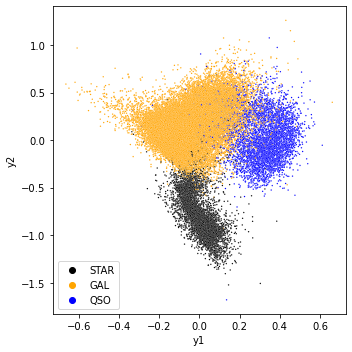

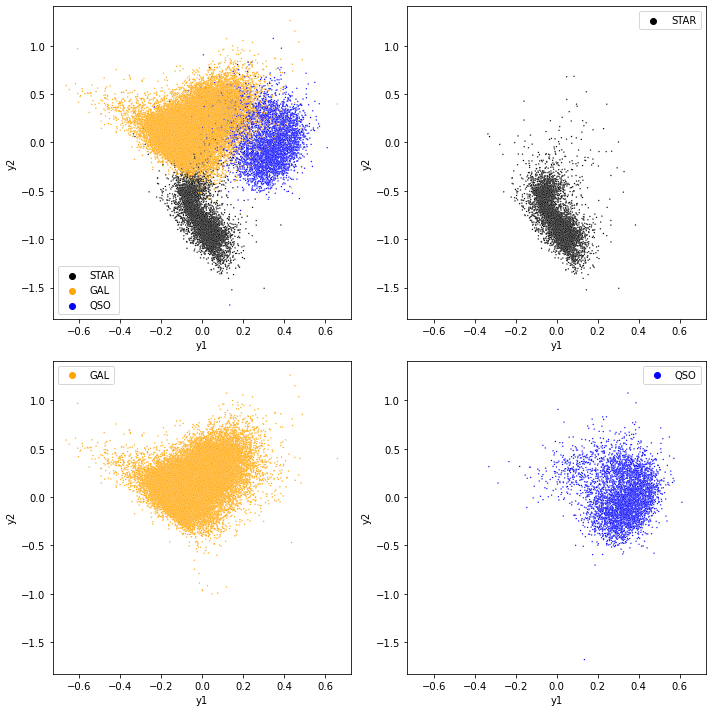

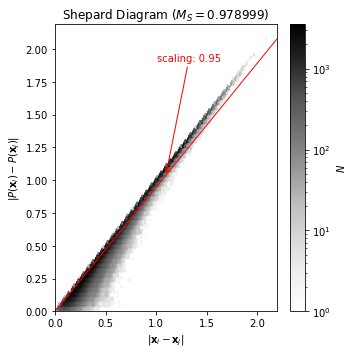

Writing data to /rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz ...
Write successful!


In [3]:
# load fits table
table = Table.read("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz", format="fits")

# extract color data & label data from table
X = np.ascontiguousarray(table[colors_STAR].to_pandas().values) # ensures X is C_CONTIGUOUS instead of F_CONTIGUOUS
labels = table[["Hclass"]].to_pandas().values.ravel()
labels = labels.astype('int8')

# find optimal DR parameters
num_samples = 1000
methods = ["LMDS"]
metric = DR_MetricsV2(k = 10) # metric class instance containing a `metric_total` method which is used for optimization
storage_path = "/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR"
param_grid = "/rdmp_data/users/lourens/master_research/data/HDBSCAN2/settings_DR.json" # path to file containing compact parameter grid
seed = 42
best_params, best_scores = optimize_DR(X, labels=labels, num_samples=num_samples, methods=methods,
                                       metric=metric, storage_path=storage_path, param_grid=param_grid,
                                       verbose=True, seed=seed)

# project full dataset using the best parameters for each DR method
for method, params in best_params.items():
    method_path = os.path.join(storage_path, method)
    tmp_path = os.path.join(method_path, "tmp")

    X = np.ascontiguousarray(table[colors_STAR].to_pandas().values)

    # apply minmax normalization to X
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False)
    scaler.fit_transform(X)
    
    reducer = SDR(path=tmp_path, data=X)
    Y_DR = reducer.apply_DR(seed=seed, method=method, **params)

    # add to fits table
    for i, col in enumerate(Y_DR.T):
        name = f"Y_{method}{i+1}"
        # check if column already exists
        if name in table.colnames:
            table.replace_column(name=name, col=col)
        else:
            table.add_column(col=col, name=name)

    # plot projection
    ax = plot_projection(projection=table[[f"Y_{method}1", f"Y_{method}2"]].to_pandas().values,
                         labels=table[["Hclass"]].to_pandas().values.ravel())
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_DR.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    # plot projection grid
    ax = plot_projection_grid(projection=table[[f"Y_{method}1", f"Y_{method}2"]].to_pandas().values,
                              labels=table[["Hclass"]].to_pandas().values.ravel())
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_grid_DR.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    # plot Shepard diagram (for random subset of dataset because of memory constraints)
    rng = np.random.default_rng(seed = seed)
    keep_samples = rng.choice(X.shape[0], size=num_samples, replace=False)
    metric.fit(X=X[keep_samples],
               Y=table[[f"Y_{method}1", f"Y_{method}2"]].to_pandas().values[keep_samples])
    MS, SD = metric.metric_shepard_goodness(return_shepard=True)
    ax = plot_shepard_diagram(SD)
    title = ax.get_title()
    ax.set_title(title + " ($M_S = {:.6f}$)".format(MS))
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_DR_Shepard_diagram.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    del reducer

# write projection data to FITS file
writeDataset(table, filename=os.path.join(storage_path, "CPz_STAR_dataset.fits.gz"), verbose=True, overwrite=True)

## LGC optimization
The process of finding the optimal parameters is similar to DR optimization. However, this time we need to use the function `optimize_LGC`. The arguments of this function are almost the same as the arguments of the `optimize_DR` function with the exception of the extra parameter `DR_params` which should specify the path to the JSON file containing the optimal DR parameters that was generated by `optimize_DR`.

Running SLMDS with LGC parameters: {'T': 10, 'alpha': 0.005, 'k': 25} and DR parameters: {'landmark_ratio': 0.02}...
    LGC in progress:    0     1     2     3     4     5     6     7     8     9 
LGC step time elapsed: 0.132725 s
Using tapkee...
DR step time elapsed: 0.005396 s
Computing metric...
	optimization metric: 0.9480880056321909

Running SLMDS with LGC parameters: {'T': 10, 'alpha': 0.005, 'k': 75} and DR parameters: {'landmark_ratio': 0.02}...
    LGC in progress:    0     1     2     3     4     5     6     7     8     9 
LGC step time elapsed: 0.242068 s
Using tapkee...
DR step time elapsed: 0.004723 s
Computing metric...
	optimization metric: 0.9435460729742668

Running SLMDS with LGC parameters: {'T': 10, 'alpha': 0.005, 'k': 125} and DR parameters: {'landmark_ratio': 0.02}...
    LGC in progress:    0     1     2     3     4     5     6     7     8     9 
LGC step time elapsed: 0.345220 s
Using tapkee...
DR step time elapsed: 0.004654 s
Computing metric...
	optimizatio

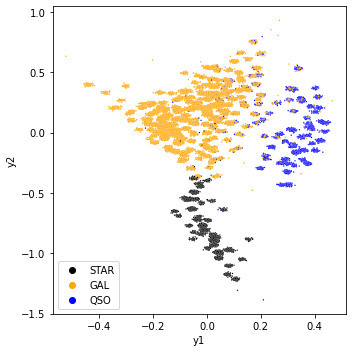

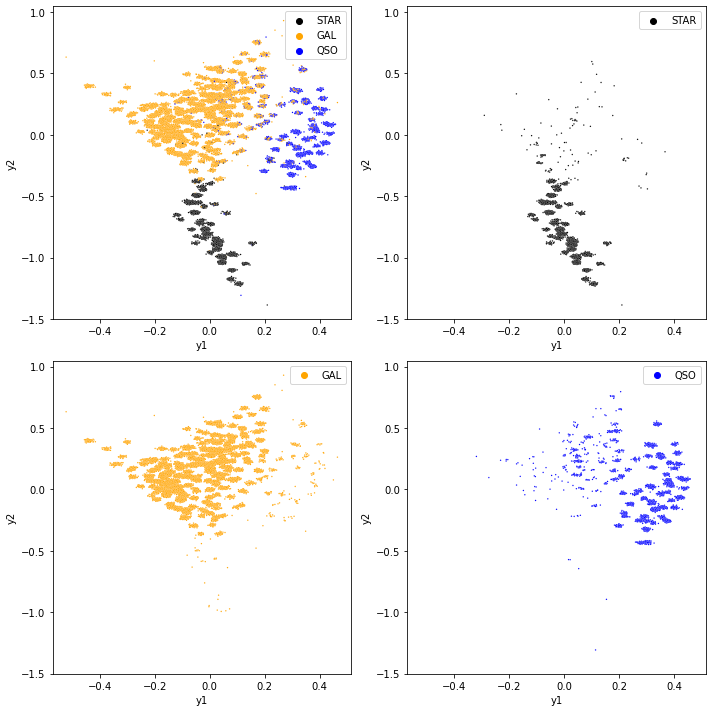

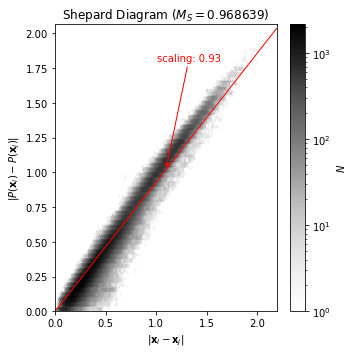

Writing data to /rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz ...
Write successful!


In [4]:
# load fits table
table = Table.read("/rdmp_data/users/lourens/master_research/data/HDBSCAN2/STAR/CPz_STAR_dataset.fits.gz", format="fits")

# extract color data & label data from table
X = np.ascontiguousarray(table[colors_STAR].to_pandas().values) # ensures X is C_CONTIGUOUS instead of F_CONTIGUOUS
labels = table[["Hclass"]].to_pandas().values.ravel()
labels = labels.astype('int8')

# find optimal LGC parameters 
metric = LGC_Metrics(k = 10) # metric class instance containing a `metric_total` method which is used for optimization
param_grid = "/rdmp_data/users/lourens/master_research/data/HDBSCAN2/settings_LGC.json" # path to file containing compact parameter grid
DR_params = os.path.join(storage_path, "best_DR_params.json")
best_params, best_scores = optimize_LGC(X, labels=labels, num_samples=num_samples, methods=methods,
                                        metric=metric, storage_path=storage_path, param_grid=param_grid,
                                        DR_params=DR_params, verbose=True, seed=seed)

DR_settings = {}
with open(DR_params, 'r') as f:
    DR_settings = json.load(f)

# project full dataset using the best parameters for each SDR method
for method, params in best_params.items():
    method_path = os.path.join(storage_path, method)
    tmp_path = os.path.join(method_path, "tmp")

    X = np.ascontiguousarray(table[colors_STAR].to_pandas().values)

    # apply minmax normalization to X
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False)
    scaler.fit_transform(X)
    
    reducer = SDR(path=tmp_path, data=X)
    reducer.apply_LGC(**params)
    Y_SDR = reducer.apply_DR(seed=seed, method=method, **DR_settings[method])

    # add to fits table
    for i, col in enumerate(Y_SDR.T):
        name = f"Y_S{method}{i+1}"
        # check if column already exists
        if name in table.colnames:
            table.replace_column(name=name, col=col)
        else:
            table.add_column(col=col, name=name)

    # plot projection
    ax = plot_projection(projection=table[[f"Y_S{method}1", f"Y_S{method}2"]].to_pandas().values,
                         labels=table[["Hclass"]].to_pandas().values.ravel())
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_SDR.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    # plot projection grid
    ax = plot_projection_grid(projection=table[[f"Y_S{method}1", f"Y_S{method}2"]].to_pandas().values,
                              labels=table[["Hclass"]].to_pandas().values.ravel())
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_grid_SDR.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    # plot Shepard diagram (for random subset of dataset because of memory constraints)
    rng = np.random.default_rng(seed = seed)
    keep_samples = rng.choice(X.shape[0], size=num_samples, replace=False)
    metric.fit(X=X[keep_samples],
               Y=table[[f"Y_S{method}1", f"Y_S{method}2"]].to_pandas().values[keep_samples])
    MS, SD = metric.metric_shepard_goodness(return_shepard=True)
    ax = plot_shepard_diagram(SD)
    title = ax.get_title()
    ax.set_title(title + " ($M_S = {:.6f}$)".format(MS))
    fig = ax.get_figure()
    fig.savefig(os.path.join(method_path, "projection_SDR_Shepard_diagram.png"), bbox_inches="tight", dpi=fig.get_dpi())
    plt.show()
    # plt.close(fig)

    del reducer

# write projection data to FITS file
writeDataset(table, filename=os.path.join(storage_path, "CPz_STAR_dataset.fits.gz"), verbose=True, overwrite=True)